* Part 1: import libraries and data
* Part 2: EDA
* Part 3: Predict the cause of wildfire
* Part 4: Try to predict if the fire was caused knowingly

**Part 1**

In [10]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree, preprocessing
import sklearn.ensemble as ske
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from subprocess import check_output
conn = sqlite3.connect("dta.sqlite")
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

The code below is sql connection.

In [11]:
data = pd.read_sql_query("SELECT * FROM 'Fires'", conn)
print(data.head())

   OBJECTID  FOD_ID      FPA_ID SOURCE_SYSTEM_TYPE SOURCE_SYSTEM  \
0         1       1  FS-1418826                FED   FS-FIRESTAT   
1         2       2  FS-1418827                FED   FS-FIRESTAT   
2         3       3  FS-1418835                FED   FS-FIRESTAT   
3         4       4  FS-1418845                FED   FS-FIRESTAT   
4         5       5  FS-1418847                FED   FS-FIRESTAT   

  NWCG_REPORTING_AGENCY NWCG_REPORTING_UNIT_ID  NWCG_REPORTING_UNIT_NAME  \
0                    FS                USCAPNF    Plumas National Forest   
1                    FS                USCAENF  Eldorado National Forest   
2                    FS                USCAENF  Eldorado National Forest   
3                    FS                USCAENF  Eldorado National Forest   
4                    FS                USCAENF  Eldorado National Forest   

  SOURCE_REPORTING_UNIT SOURCE_REPORTING_UNIT_NAME  ... FIRE_SIZE_CLASS  \
0                  0511     Plumas National Forest  ...    

The only columns we need are "FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE"

In [12]:
data = pd.read_sql_query("SELECT FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE FROM 'Fires'", conn)
print(data.head())

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  \
0       2005    Miscellaneous  40.036944 -121.005833    CA       2453403.5   
1       2004        Lightning  38.933056 -120.404444    CA       2453137.5   
2       2004   Debris Burning  38.984167 -120.735556    CA       2453156.5   
3       2004        Lightning  38.559167 -119.913333    CA       2453184.5   
4       2004        Lightning  38.559167 -119.933056    CA       2453184.5   

   FIRE_SIZE  
0       0.10  
1       0.25  
2       0.10  
3       0.10  
4       0.10  


In [13]:
df= data[data.STAT_CAUSE_DESCR != 'Miscellaneous']

In [14]:
df= data[data.STAT_CAUSE_DESCR != 'Missing/Undefined']

In [15]:
data = df

In [16]:
data.to_csv(r'D:\ST.CLAIR\Data.csv', index = False)

The most weird part of this dataset is the date format which is in JUILIAN format , its been converted into Georgian so that it is generalized.

In [17]:
data['DATE'] = pd.to_datetime(data['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
print(data.head()) #check the data

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  \
0       2005    Miscellaneous  40.036944 -121.005833    CA       2453403.5   
1       2004        Lightning  38.933056 -120.404444    CA       2453137.5   
2       2004   Debris Burning  38.984167 -120.735556    CA       2453156.5   
3       2004        Lightning  38.559167 -119.913333    CA       2453184.5   
4       2004        Lightning  38.559167 -119.933056    CA       2453184.5   

   FIRE_SIZE       DATE  
0       0.10 2005-02-02  
1       0.25 2004-05-12  
2       0.10 2004-05-31  
3       0.10 2004-06-28  
4       0.10 2004-06-28  


In [35]:
data['MONTH'] = pd.DatetimeIndex(data['DATE']).month
data['DAY_OF_WEEK'] = data['DATE'].dt.day_name
data_orig = data.copy()
print(data.head())

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  \
0       2005    Miscellaneous  40.036944 -121.005833    CA       2453403.5   
1       2004        Lightning  38.933056 -120.404444    CA       2453137.5   
2       2004   Debris Burning  38.984167 -120.735556    CA       2453156.5   
3       2004        Lightning  38.559167 -119.913333    CA       2453184.5   
4       2004        Lightning  38.559167 -119.933056    CA       2453184.5   

   FIRE_SIZE       DATE  MONTH  \
0       0.10 2005-02-02      2   
1       0.25 2004-05-12      5   
2       0.10 2004-05-31      5   
3       0.10 2004-06-28      6   
4       0.10 2004-06-28      6   

                                         DAY_OF_WEEK  
0  <bound method PandasDelegate._add_delegate_acc...  
1  <bound method PandasDelegate._add_delegate_acc...  
2  <bound method PandasDelegate._add_delegate_acc...  
3  <bound method PandasDelegate._add_delegate_acc...  
4  <bound method PandasDelegate._add_delegate_acc..

In [36]:
data.to_csv(r'D:\ST.CLAIR\Data_mod.csv', index = False)

**Part 2**

**Exploratory Data Analysis (EDA):**

Let us first start looking at the cause of fires

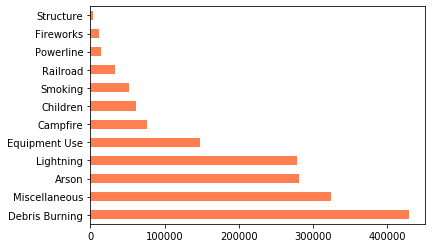

In [37]:
data['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='coral')
plt.show()

So there are 13 causes of fire to be precise let us see if there is any unique pattern regarding the weekdays the fire is caused.

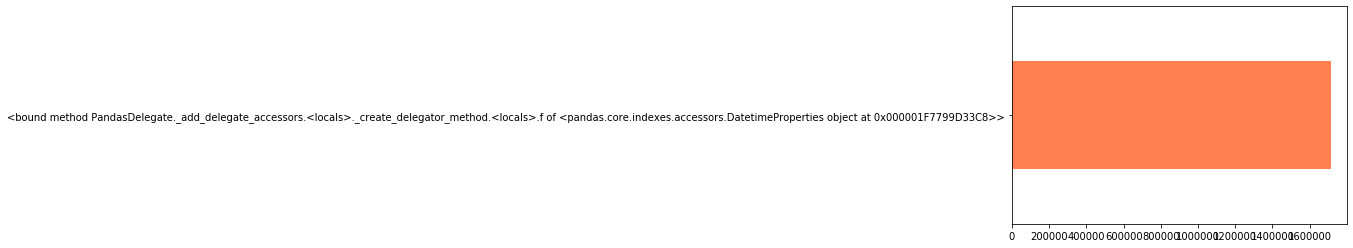

In [38]:
data['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral')
plt.show()

    All the days of week look almost looks same. Let us see the top caused reason for Fire.

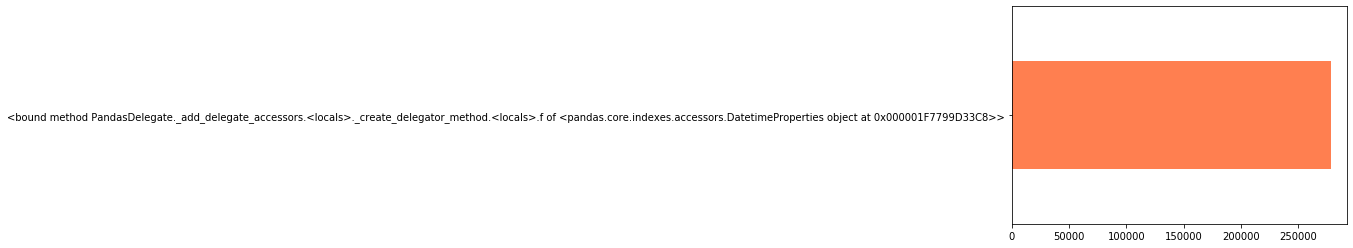

In [39]:
lightning = data[data['STAT_CAUSE_DESCR']=='Lightning']
lightning['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral')
plt.show()

    Due to lightning the pattern is different so maybe the increase of fire on weekends could be because of man caused fire.

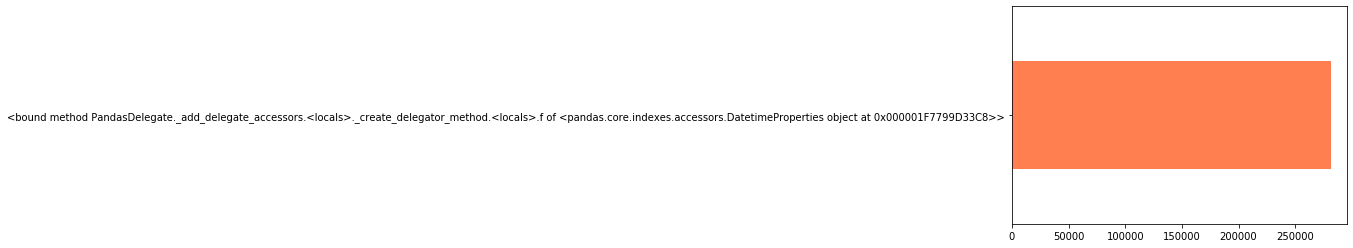

In [40]:
arson = data[data['STAT_CAUSE_DESCR']=='Arson']
arson['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral')
plt.show()

The ARSON(MAN CAUSED) fire shows a good information that most of them are on weekend that means it could be because of campfires or similar things.

Let us divide them by states now?

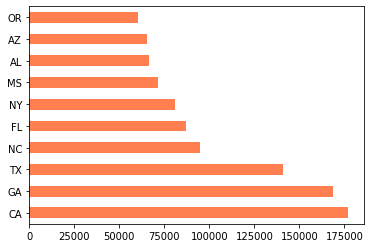

In [41]:
data['STATE'].value_counts().head(n=10).plot(kind='barh',color='coral')
plt.show()

Let us norrow down to top 3

In [42]:
CA = data[data['STATE']=='CA']
GA = data[data['STATE']=='GA']
TX = data[data['STATE']=='TX']

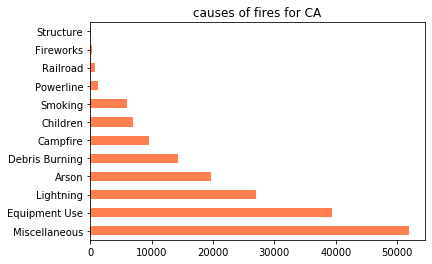

In [43]:
CA['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='coral',title='causes of fires for CA')
plt.show()

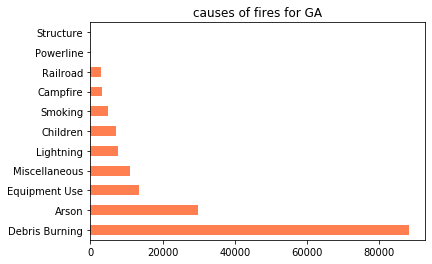

In [44]:
GA['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='coral',title='causes of fires for GA')
plt.show()

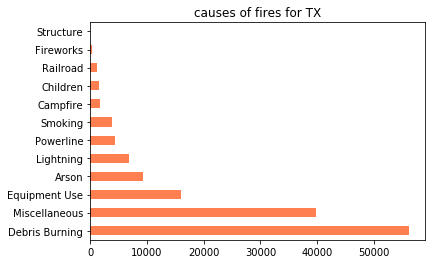

In [45]:
TX['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='coral',title='causes of fires for TX')
plt.show()

Let us create a rough map using scatter plot as we have the Latitude and Longitude

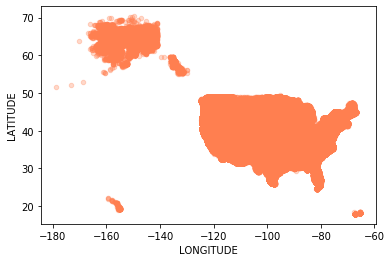

In [46]:
data.plot(kind='scatter',x='LONGITUDE',y='LATITUDE',color='coral',alpha=0.3)
plt.show()

There are lot of categories in this dataset so let us use One Hot Encoding to find the correlation between all these.

In [47]:
le = preprocessing.LabelEncoder()
data['STAT_CAUSE_DESCR'] = le.fit_transform(data['STAT_CAUSE_DESCR'])
data['STATE'] = le.fit_transform(data['STATE'])
data['DAY_OF_WEEK'] = le.fit_transform(data['DAY_OF_WEEK'])
print(data.head())

   FIRE_YEAR  STAT_CAUSE_DESCR   LATITUDE   LONGITUDE  STATE  DISCOVERY_DATE  \
0       2005                 7  40.036944 -121.005833      4       2453403.5   
1       2004                 6  38.933056 -120.404444      4       2453137.5   
2       2004                 3  38.984167 -120.735556      4       2453156.5   
3       2004                 6  38.559167 -119.913333      4       2453184.5   
4       2004                 6  38.559167 -119.933056      4       2453184.5   

   FIRE_SIZE       DATE  MONTH  DAY_OF_WEEK  
0       0.10 2005-02-02      2            0  
1       0.25 2004-05-12      5            0  
2       0.10 2004-05-31      5            0  
3       0.10 2004-06-28      6            0  
4       0.10 2004-06-28      6            0  


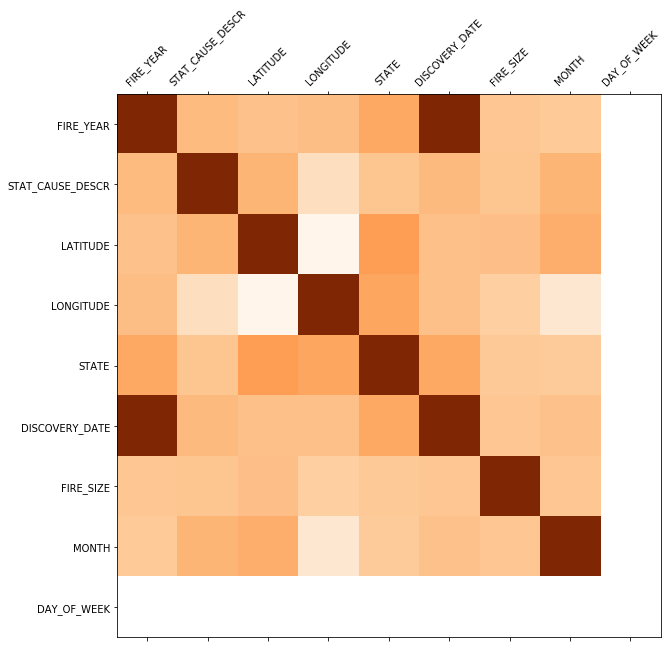

In [48]:
def plot_corr(data,size=10):
    corr = data.corr()  #the default method is pearson
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr,cmap=plt.cm.Oranges)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)    
    plt.show()
    

    
plot_corr(data)

Good correlation between month and latitude, weather and season are related, less correlation between longitude and month
& No Correlation of Target variable with any

**Part 3**

**Preparing the data for machine learning**

Dropping the Dates and NA's

In [49]:
data = data.drop('DATE',axis=1)
data = data.dropna()

Our Target variable is Cause of Fire(" STAT_CAUSE_DESCR ")

In [50]:
X = data.drop(['STAT_CAUSE_DESCR'], axis=1).values
y = data['STAT_CAUSE_DESCR'].values

Logistic Regression

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0) #30% for testing, 70% for training

In [52]:
regr = linear_model.LinearRegression()

In [53]:
# Train the model using the training sets
regr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [54]:
# Make predictions using the testing set
y_pred = regr.predict(X_test)

In [55]:
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test,y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test,y_pred))

Coefficients: 
 [ 3.60261607e-01  1.02836719e-02 -2.56735414e-02  4.57186647e-03
 -9.12902449e-04  6.17059500e-06  8.13555053e-02  0.00000000e+00]
Mean squared error: 7.32
Coefficient of determination: 0.04


In [56]:
regr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [57]:
regr.score(X_train, y_train)

0.03602787016554121

In [58]:
regr.fit(X_test,y_test)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [59]:
regr.score(X_test, y_test)

0.035932645368474736

Decision Tree

In [60]:
from sklearn import tree

In [61]:
tree.plot_tree(clf.fit(X_train,y_train))

NameError: name 'clf' is not defined

In [ ]:
clf = tree.DecisionTreeRegressor(max_depth=35)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
clf.score(X_train, y_train)

In [ ]:
clf.fit(X_test, y_test)

In [ ]:
clf.score(X_test, y_test)

Random Forest

In [ ]:
clf_rf = ske.RandomForestClassifier(n_estimators=50)
clf_rf = clf_rf.fit(X_train, y_train)
print(clf_rf.score(X_test,y_test))

Let us narrow down the classes as there are a lot of classes related to the cause of fire and wich could be tideous while predicting the cause of it.

In [ ]:
def set_label(cat):
    cause = 0
    natural = ['Lightning']
    accidental = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
    malicious = ['Arson']
    other = ['Missing/Undefined','Miscellaneous']
    if cat in natural:
        cause = 1
    elif cat in accidental:
        cause = 2
    elif cat in malicious:
        cause = 3
    else:
        cause = 4
    return cause
     

data['LABEL'] = data_orig['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x)) # I created a copy of the original data earlier in the kernel
data = data.drop('STAT_CAUSE_DESCR',axis=1)
print(data.head())

Let us try to predict the LABEL now.

In [ ]:
X = data.drop(['LABEL'], axis=1).values
y = data['LABEL'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)
clf_rf = ske.RandomForestClassifier(n_estimators=50)
clf_rf = clf_rf.fit(X_train, y_train)
print(clf_rf.score(X_test,y_test))

Reducing the Classes did turn out to be a good decision

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = clf_rf.fit(X_train, y_train).predict(X_test)
cm = confusion_matrix(y_true=y_test,y_pred=y_pred)
print(cm)

Accuracy and Confusion matrix simplified according to Label below

In [ ]:
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig,ax = plt.subplots(figsize=(10,10))
ax.matshow(cmn,cmap=plt.cm.Oranges,alpha=0.7)
for i in range(cmn.shape[0]):
    for j in range(cmn.shape[1]):
        ax.text(x=j,y=i,s=cmn[i,j],va='center',ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

**Part 4**

Narrowing down to States

In [ ]:
print(CA.head())

Create a new field: ARSON

In [ ]:
def set_arson_label(cause):
    arson = 0
    if cause == 'Arson':
        arson = 1
    return arson
     

CA['ARSON'] = CA['STAT_CAUSE_DESCR'].apply(lambda x: set_arson_label(x)) 
print(CA.head())

We can drop the DATE, STATE, FIRE_SIZE and STAT_CAUSE_DESCR fields and convert the DAY_OF_WEEK to numerical values.

In [ ]:
le = preprocessing.LabelEncoder()
CA['DAY_OF_WEEK'] = le.fit_transform(CA['DAY_OF_WEEK'])

print(CA.head())

# From Here 

In [61]:
data1 = pd.read_sql_query("SELECT STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,FIRE_SIZE FROM 'Fires'", conn)
print(data1.head())
data1_orig = data1.copy()

  STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  FIRE_SIZE
0    Miscellaneous  40.036944 -121.005833    CA       0.10
1        Lightning  38.933056 -120.404444    CA       0.25
2   Debris Burning  38.984167 -120.735556    CA       0.10
3        Lightning  38.559167 -119.913333    CA       0.10
4        Lightning  38.559167 -119.933056    CA       0.10


In [62]:
def set_label(cat):
    cause = 0
    natural = ['Lightning']
    accidental = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
    malicious = ['Arson']
    other = ['Missing/Undefined','Miscellaneous']
    if cat in natural:
        cause = 1
    elif cat in accidental:
        cause = 2
    elif cat in malicious:
        cause = 3
    else:
        cause = 4
    return cause
     

data1['LABEL'] = data1_orig['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x)) # I created a copy of the original data earlier in the kernel
data1 = data1.drop('STAT_CAUSE_DESCR',axis=1)
print(data.head())

   FIRE_YEAR   LATITUDE   LONGITUDE  STATE  DISCOVERY_DATE  FIRE_SIZE  MONTH  \
1       2004  38.933056 -120.404444      4       2453137.5       0.25      5   
2       2004  38.984167 -120.735556      4       2453156.5       0.10      5   
3       2004  38.559167 -119.913333      4       2453184.5       0.10      6   
4       2004  38.559167 -119.933056      4       2453184.5       0.10      6   
5       2004  38.635278 -120.103611      4       2453186.5       0.10      6   

   DAY_OF_WEEK  LABEL  
1            6      1  
2            1      2  
3            1      1  
4            1      1  
5            6      1  


In [72]:
le = preprocessing.LabelEncoder()
data1['STATE'] = le.fit_transform(data1['STATE'])

print(data1.head())

    LATITUDE   LONGITUDE  STATE  FIRE_SIZE  LABEL
0  40.036944 -121.005833      4       0.10      4
1  38.933056 -120.404444      4       0.25      1
2  38.984167 -120.735556      4       0.10      2
3  38.559167 -119.913333      4       0.10      1
4  38.559167 -119.933056      4       0.10      1


In [73]:


X = data1.drop(['LABEL'], axis=1).values
y = data1['LABEL'].values
Xx_train, Xx_test, yy_train, yy_test = train_test_split(X,y,test_size=0.3, random_state=0)

In [ ]:
from sklearn.svm import SVC
svc = SVC(kernel = 'rbf', C= 10, gamma =0.1) 
svc.fit(Xx_train,yy_train)

In [ ]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

In [ ]:
#Train the model using the training sets
clf.fit(X_train, y_train)

In [ ]:

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

We can now test the ML:

In [ ]:
X = CA.drop(['ARSON'], axis=1).values
y = CA['ARSON'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0) #30% for testing, 70% for training
clf_rf = ske.RandomForestClassifier(n_estimators=200)
clf_rf = clf_rf.fit(X_train, y_train)
print(clf_rf.score(X_test,y_test))

Summary:
Given some basic data, the kind of data available when a fire is first discovered, it is possible to predict with some accuracy if the firs wa the result of arson.